# Two Nucleon Scattering #

Consider two nucleons each of mass $m=938$ MeV/$c^2$
interacting via a central potential given by

$$
V(r) = 
\begin{cases}
              -V_0\, \quad\quad           & \text{for }                r \leq R \,  \\
{\color{white}-}0 \, \quad\quad           & \text{otherwise }\,  \\
\end{cases}
$$

where $V_0$ is positive and $R=1.45$ fm.

In [1]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

## Numerov's algorithm ##

We seek the solution, $u(r)=r\,R(r)$, of the radial equation
\begin{equation}
 -\frac{\hbar^2}{2\,\mu}u^{\prime\prime}(r) +V(r)\,u(r) +\frac{\ell(\ell+1)}{r^2}=E\,u(r)\, ,
\end{equation}
where 
\begin{eqnarray}
 E&=&\frac{\hbar^2\,k^2}{2\,\mu}\, , \quad {\rm and}\quad \quad  \mu=\frac{m}{2} \, .
\end{eqnarray}
We define
\begin{equation}
 v(r)=\frac{2\,\mu}{\hbar^2}\,V(r) \, ,
\end{equation}
and rewrite the equation above  as
\begin{eqnarray}
&& u^{\prime\prime}(r) +\left[k^2 - v(r)\,u(r) -\frac{\ell(\ell+1)}{r^2}\right]\,u(r)=0\, ,\nonumber 
\end{eqnarray}
or
\begin{eqnarray}
&& u^{\prime\prime}(r) + K(r) u(r)=0 \, ,
\end{eqnarray}
with 
\begin{equation}
 K(r)=\frac{2\,\mu}{\hbar^2}\left[E-V(r)\right] - \frac{\ell(\ell+1)}{r^2} \, .
\end{equation}

As $r\rightarrow 0$, $u(r)\rightarrow r^{(\ell+1)}$. We use two grid points 
close to zero *e.g.*, $r_1=h$ and $r_2=2\times h$, where $h$ is the 
step in $r$), and the solution calculated in these points, that is 
$u_1=u(r_1)=h^{\ell+1}$ and $u_2=u(r_2)=(2\times h)^{\ell+1}$, to start building the
solution outwards using the Numerov's method. 

The subsequent $u_i$'s calculated at $r_i$'s are obtained using the following
algorithm
\begin{equation}
u_{i+1}\left(1+\frac{h^2}{12}K_{i+1} \right) -u_i\,\left(2-\frac{5\,h^2}{6}K_i\right)+
u_{i-1}\left(1+\frac{h^2}{12}K_{i-1} \right) +O(h^6)=0 \nonumber \, . 
\end{equation}
 
You will need the physical constant $\hbar\,c = 197.326980$ MeV fm.

In [2]:
#Lets define some common variables
mu = 938/2 #MeV/c^2
hbarc = 197.326980 #MeV fm

In [56]:
def numerovWF(E,V0,R,l,n,Rmax):
    '''Uses Numerov's algorithm to solve the radial equation and get the wavefunction for a nucleon 
    with energy E, scattered off of a potential V0. l is the angular momentum of the partial wave
    under consideration.
    n=number of points
    R=radius of potential
    Rmax=max integration point'''

    h = Rmax/n

    #Set up array for wavefuntion
    wavefunc = np.zeros(n)
    r = np.arange(h, Rmax+h, h)
    V = np.zeros_like(r)

    for i in range(len(V)):
        if r[i] <= R:
            V[i] = V0

    K = 2*mu/hbarc**2*(E*np.ones_like(r) - V) - l*(l+1)/r**2

    #solve approximation for first two steps r0 and r1
    wavefunc[0] = r[0]**(l+1)
    wavefunc[1] = r[1]**(l+1)

    #loop over the rest of the wavefunction calculating r_i+1
    for i in range(2,n):
        wavefunc[i] = 1/(1+h**2/12*K[i])*(wavefunc[i-1]*(2-5*h**2*K[i-1]/6) - wavefunc[i-2]*(1+h**2*K[i-2]/12))
        
    return wavefunc

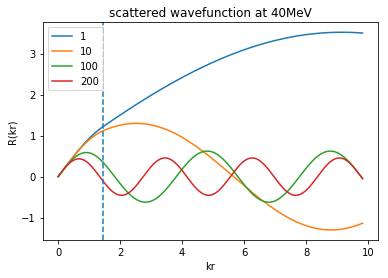

In [92]:
E = 40
V0 = -20
R = 1.45
l = 0
n = 10000
Rmax = 10
k = np.sqrt(2*mu*E/hbarc**2)

h = Rmax/n 
r = np.arange(h, Rmax+h, h)

energies = [1,10,100,200]
for e in energies:
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    plt.plot(k*r, wavefunc, label=e)

plt.title("scattered wavefunction at {}MeV".format(E))
plt.axvline(x=R,ls='--')
plt.legend()
plt.ylabel("R(kr)")
plt.xlabel("kr")
# plt.ylim(-0.5,10)
# plt.savefig("Wavefunc_l={}_{}MeV.png".format(l,E), format="png")
plt.show()

## phaseshifts ##

just copy paste some latex stuff we write about this :)

In [83]:
def phaseshift(wavefunc,E,l,n,Rmax):
    '''Get the phaseshift from a scattered wave'''
    h = Rmax/n
    r1 = Rmax - h
    r2 = Rmax
    
    #get wave momentum
    k = np.sqrt(2*mu*E/hbarc**2)
    alpha = (wavefunc[len(wavefunc)-2]/r1)/(wavefunc[len(wavefunc)-1]/r2)
    
    tandelta_n = np.abs(sp.spherical_jn(l,k*r1) - alpha*sp.spherical_jn(l,k*r2))
    tandelta_d = np.abs(sp.spherical_yn(l,k*r1) - alpha*sp.spherical_yn(l,k*r2)) 
    phaseshift = np.arctan2(tandelta_n,tandelta_d)
    
    return phaseshift

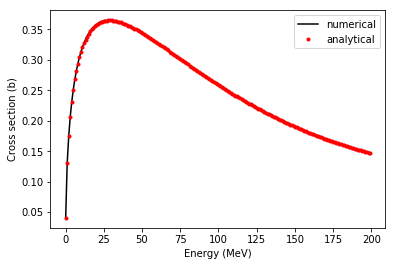

In [93]:
def phaseshift_analytical(E,V0):
    
    K1 = np.sqrt(2*mu/hbarc**2*(E - V0))
    K0 = np.sqrt(2*mu*E/hbarc**2)
    
    #tandelta = (np.cos(K0*R)*np.sin(K1*R) - K1/K0*np.cos(K1*R)*np.sin(K0*R))/ \
    #                (K1/K0*np.cos(K1*R)*np.cos(K0*R) + np.sin(K1*R)*np.sin(K0*R))
    tandelta_n = np.abs(np.cos(K0*R)*np.sin(K1*R) - K1/K0*np.cos(K1*R)*np.sin(K0*R))
    tandelta_d = np.abs(K1/K0*np.cos(K1*R)*np.cos(K0*R) + np.sin(K1*R)*np.sin(K0*R))
    
    phaseshift = np.arctan2(tandelta_n,tandelta_d)
    #phaseshift = np.arctan(tandelta)
    
    return phaseshift


l=0
phases = []
phases_analytical = []
energies = np.arange(0.1,200,1)
for e in energies:
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    ps = phaseshift(wavefunc, e, l, n, Rmax)
    ps_analytical = phaseshift_analytical(e,V0)
    
    phases.append(ps)
    phases_analytical.append(ps_analytical)

plt.plot(energies, phases, color='black', label="numerical")
plt.plot(energies, phases_analytical, 'r.', label="analytical")
plt.legend()
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross section (b)")
plt.show()

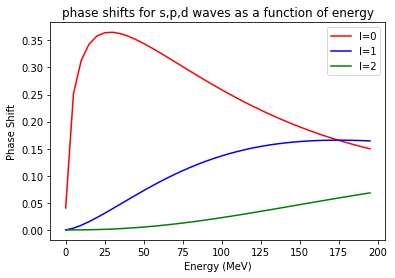

In [94]:
colors = ["red","blue","green"]
for l in range(3):
    phases = []
    energies = np.arange(0.1,200,5)
    for e in energies:
        wavefunc = numerovWF(e, V0, R, l, n, Rmax)
        ps = phaseshift(wavefunc, e, l, n, Rmax)
        phases.append(ps)

    plt.plot(energies, phases, color=colors[l], label="l={}".format(l))

    
plt.title("phase shifts for s,p,d waves as a function of energy")    
plt.xlabel("Energy (MeV)")
plt.ylabel("Phase Shift")
plt.legend()
plt.show()

## Cross section ##

In [95]:
def partial_xsection(l,ps,E):
    
    k = np.sqrt(2*mu*E/hbarc**2)
    xsec = (2*l+1)*4*np.pi*(np.sin(ps)**2)/k**2
    return xsec


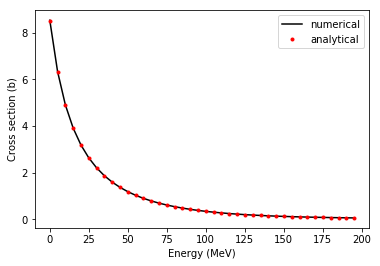

In [96]:
energies = np.arange(0.1,200,5)

xsecs = []
xsecs_analytical = []
l = 0
for i,e in enumerate(energies):
    wavefunc = numerovWF(e, V0, R, l, n, Rmax)
    ps = phaseshift(wavefunc, e, l, n, Rmax)
    ps_analytical = phaseshift_analytical(e,V0)
    
    xsec = partial_xsection(l,ps,e)
    xsec_analytical = partial_xsection(l,ps_analytical,e)
    
    xsecs.append(xsec)
    xsecs_analytical.append(xsec_analytical)
    
plt.plot(energies, xsecs, "k-",label="numerical")
plt.plot(energies, xsecs_analytical, 'r.', label="analytical")
plt.legend()
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross section (b)")
plt.show()

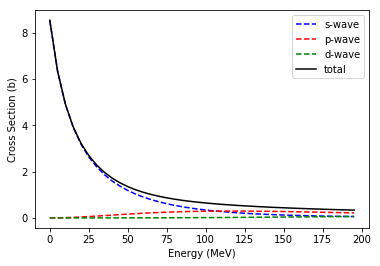

In [97]:
energies = np.arange(0.1,200,5)

xsecs_all = np.zeros((3,len(energies)))
for l in range(3):
    for i,e in enumerate(energies):
        wavefunc = numerovWF(e, V0, R, l, n, Rmax)
        ps = phaseshift(wavefunc, e, l, n, Rmax)
        xsec = partial_xsection(l,ps,e)
        xsecs_all[l][i] = xsec
plt.plot(energies, xsecs_all[0], 'b--', label="s-wave")
plt.plot(energies, xsecs_all[1], 'r--', label="p-wave")
plt.plot(energies, xsecs_all[2], 'g--', label="d-wave")
plt.plot(energies, xsecs_all[0]+xsecs_all[1]+xsecs_all[2], 'k', label="total")
plt.legend()
plt.xlabel("Energy (MeV)")
plt.ylabel("Cross Section (b)")
plt.show()